In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import os
from joblib import dump
from dynaconf import settings
import pyodbc
import logging
from joblib import Memory
from train_and_pred import *

In [2]:
def load_data(nmi_id, start_date, end_date, facts=[], test_dates=[]):
    df_nmi_X, df_nmi_Y = get_train_test_data(nmi_id, start_date, end_date)
    df_nmi_test_X, df_nmi_train_X, df_nmi_test_y, df_nmi_train_y = train_test_split(df_nmi_X, df_nmi_Y, test_dates)
    df_nmi_train_X, df_nmi_test_X, df_LLM, codes = integrate_domain_knowledge(df_nmi_train_X, df_nmi_test_X, facts)
    df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y = prep_train_test_data(df_nmi_train_X, df_nmi_test_X, df_nmi_train_y, df_nmi_test_y)
    model, rmse_train, mape_train = train_model(df_nmi_train_X, df_nmi_train_y, nmi_id, facts)
    df_nmi_test_y_pred, rmse_test, mape_test = predict_model(model, df_nmi_test_X, df_nmi_test_y)   
    df_future_dates, y_pred, df_LLM_future = forecast_nmi_consumption(model, nmi_id, start_date, end_date, codes)

    return mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_LLM_future

def get_all_meter_details():
    df_meter_info = get_meter_info()
    meter_dict = {row['NetworkID'] : row['Name'] for _, row in df_meter_info.iterrows()}
    campus_dict = {row['NetworkID'] : row['CampusKey'] for _, row in df_meter_info.iterrows()}
    return meter_dict, campus_dict

In [3]:
meter_dict, campus_dict = get_all_meter_details()

In [5]:
import json
with open('metadata/facts.json', 'r') as f:
    facts_data = json.load(f)

with open('metadata/train_test_split.json', 'r') as f:
    test_split_data = json.load(f)


USE_FACTS = True

# for nmi_id, nmi_name in meter_dict.items():
for i in range(1,2):
    nmi_id = 2
    campus_key = campus_dict[nmi_id]
    start_date = '20180101'
    end_date   = '20250601'

    # Get facts for the current campus
    facts = facts_data.get(str(nmi_id), [])
    test_split = test_split_data.get(str(nmi_id), {})
    
    if USE_FACTS:
        mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, df_LLM, df_LLM_future = load_data(nmi_id, start_date, end_date, facts=facts, test_dates=test_split)
    else:
        mape_test, df_nmi_X, df_nmi_Y, df_future_dates, y_pred, _, _ = load_data(nmi_id, start_date, end_date, test_dates=test_split)





Fact: During Covid-19, there was a period of where campus was closed and hence the consumption was lower than expected
Code: import pandas as pd

# Sample dataframe creation for demonstration purposes
# df_LLM = pd.DataFrame({'DatePlot': pd.date_range(start='2018-01-01', end='2021-12-31')})

# Define the start and end dates of the campus closure period
closure_start_date = pd.to_datetime('2020-03-15')
closure_end_date = pd.to_datetime('2020-08-31')

# Function to determine if a date is within the closure period
def is_during_closure(date):
    if closure_start_date <= date <= closure_end_date:
        return 1
    else:
        return 0

# Apply the function to the DatePlot column to create the new numerical feature
df_LLM['CampusClosure'] = df_LLM['DatePlot'].apply(lambda x: is_during_closure(pd.to_datetime(x)))

# Display the first few rows of the dataframe to verify the new column
print(df_LLM.head())
    DateKey   DatePlot  ApparentTemperature  AirTemperature  \
0  20180101 2018-01

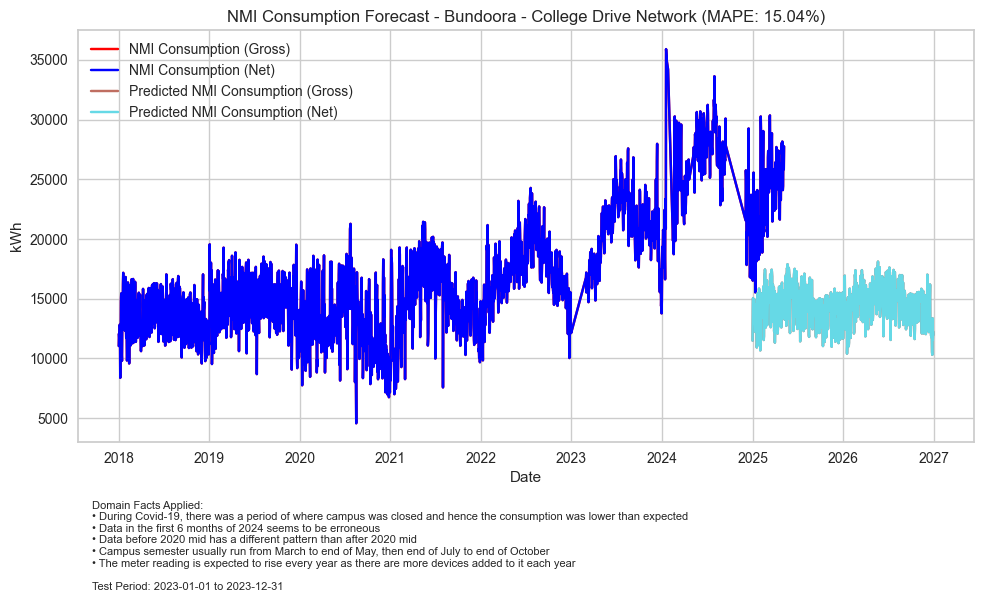

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['consumption'], label='NMI Consumption (Gross)', color='red')
ax.plot(df_nmi_Y['DatePlot'], df_nmi_Y['metered_consumption'], label='NMI Consumption (Net)', color='blue')
ax.plot(df_future_dates['DatePlot'], y_pred, label='Predicted NMI Consumption (Gross)', color=(0.75, 0.43, 0.38))
ax.plot(
    df_future_dates['DatePlot'],
    y_pred ,
    color=(0.4, 0.85, 0.9),
    label='Predicted NMI Consumption (Net)'
)

ax.set_title(f"NMI Consumption Forecast - {meter_dict[nmi_id]} (MAPE: {mape_test:.2%})")
ax.set_xlabel("Date")
ax.set_ylabel("kWh")
ax.legend()
ax.grid(True)

# Add facts and test dates information at the bottom of the plot
info_text = ""
if USE_FACTS and facts:
    info_text += "Domain Facts Applied:\n" + "\n".join([f"• {fact}" for fact in facts])
else:
    info_text += "Domain Facts: Disabled"

if test_split:
    test_start = str(test_split.get('test_start_date', ''))
    test_end = str(test_split.get('test_end_date', ''))
    if test_start and test_end:
        # Format dates for display
        test_start_formatted = f"{test_start[:4]}-{test_start[4:6]}-{test_start[6:]}"
        test_end_formatted = f"{test_end[:4]}-{test_end[4:6]}-{test_end[6:]}"
        info_text += f"\n\nTest Period: {test_start_formatted} to {test_end_formatted}"

plt.figtext(0.1, 0, info_text, fontsize=8, wrap=True, ha='left', va='bottom')
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)

In [7]:
print(df_LLM.columns)
print(df_LLM_future.columns)


Index(['DateKey', 'DatePlot', 'ApparentTemperature', 'AirTemperature',
       'DewPointTemperature', 'RelativeHumidity', 'Day', 'Weekday',
       'IsWeekend', 'IsHoliday', 'DOWInMonth', 'WeekOfMonth', 'WeekOfYear',
       'Month', 'Quarter', 'Year', 'set', 'CampusClosure', 'ErroneousFlag',
       'PatternChange', 'IsSemester', 'YearsSinceStart'],
      dtype='object')
Index(['ApparentTemperature', 'AirTemperature', 'DewPointTemperature',
       'RelativeHumidity', 'Day', 'Weekday', 'IsWeekend', 'IsHoliday',
       'DOWInMonth', 'WeekOfMonth', 'WeekOfYear', 'Month', 'Quarter', 'Year',
       'DatePlot', 'CampusClosure', 'ErroneousFlag', 'PatternChange',
       'IsSemester', 'YearsSinceStart'],
      dtype='object')


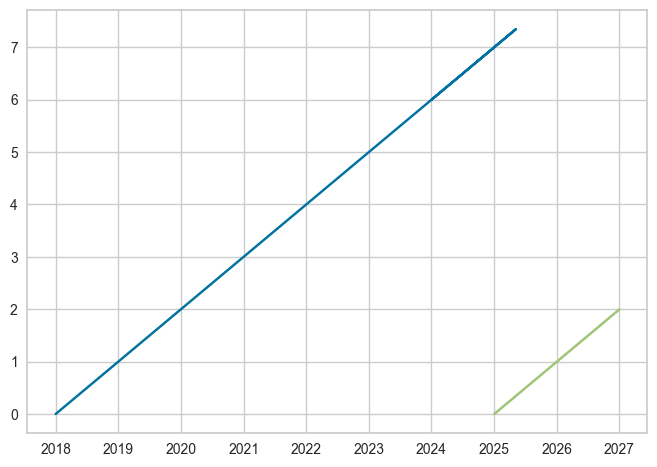

In [8]:
feature = 'YearsSinceStart'
df_LLM['DatePlot'] = pd.to_datetime(df_LLM['DatePlot'])
df_LLM_future['DatePlot'] = pd.to_datetime(df_LLM_future['DatePlot'])
plt.plot(df_LLM['DatePlot'], df_LLM[feature])
plt.plot(df_LLM_future['DatePlot'], df_LLM_future[feature])
